# Базові моделі класифікації з використанням бібліотеки Scikit-Learn  
Алгоритм класифікації – це метод навчання з вчителем, який використовується для визначення категорії нових спостережень на основі даних навчання. Модель класифікації навчається на основі заданого набору даних або спостережень, а потім класифікує нове спостереження на кілька класів або груп. Наприклад, «Так» або «Ні», 0 або 1, «Спам» або «Не спам», «кіт» або «собака» тощо. Класи можна називати цілями/мітками або категоріями.  

#### На відміну від регресії, цільова (залежна) змінна в моделях класифікації є категорією, а не значенням.  Наприклад "зелений або синій", "фрукт або тварина", тощо.     

Прикладами задач класифікації можуть бути:  
- Розподіл коментарів Twitter за тональністю – позитивні чи негативні.
- Прийняття рішень про надання позначки "спам" повідомленню електронної пошти.
- Визначення того, чи фотографія містить певний елемент, наприклад зображення собаки або котика.  


**Виділяють такі типи задач класифікації:**  
1. Бінарна класифікація – групування результату в одну з двох груп.
2. Багатокласова  класифікація  –  групування результату в одну з декількох (більше двох) груп.  
В рамках даного курсу ми не розглядатимемо задачі багатокласової класифікації, а зосередимо увагу тільки на задачах бінарної класифікації.

Scikit-Learn надає доступ до різних алгоритмів класифікації. Ми розглянемо приклад практичної реалізації таких алгоритмів класифікації:  
- метод  k-найближчих  сусідів  (K-Nearest Neighbors);
- метод  опорних  векторів  (Support  Vector Machines);
- логістична регресія (Logistic Regression).  

In [ ]:
#імпортуємо необхідні бібліотеки
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# зчитаємо файл з початковими даними в датафрейм data
df = pd.read_csv('audit_risk.csv')
df.head()

### Опис датафрейму  
_Необхідно допомогти аудиторам, побудувавши класифікаційну модель, яка може класифікувати(розпізнати) шахрайську фірму на основі поточних та ретроспективних факторів ризику_  

Sector_score - репутаційна оцінка організації у відповідному секторі    
Score_A - оцінка виявлених під час перевірки невідповідностей у запланованих витратах фірми    
Score_B - оцінка виявлених під час перевірки невідповідностей у незапланованих витратах фірми    
TOTAL - загальний розмір виявлених невідповідностей у витратах фірми    
numbers - к-ть виявлених під час перевірки невідповідностей у витратах фірми у минулому  
Score_MV - рейтингова оцінка фірми, пов'язана недобросовісним використанням коштів під час минулих аудиторських перевірок    
District_Loss - історична оцінка ризику для галузі, в якій працює фірма, за останні 10 років    
History - середній збиток фірми за останні 10 років   
Inherent_Risk, CONTROL_RISK, Audit_Risk - оцінка внутрішнього ризику, ризику контролю та аудиторського ризику відповідно  
**Цільова (таргетована, залежна) змінна:**   
Risk - клас ризику, присвоєний аудиторській справі:  
- 1 - «шахрайські» фірми  
- 0 - «нешахрайські» фірми

## 1. Підготовка даних

In [ ]:
# Перевіримо дані на наявність пропусків. Якщо є пропуски, їх обов'язково необхідно заповнити або видалити!
# Якщо є категоріальні ознаки, їх необхідно обов'язково перекодувати в числові!
df.info()

Пропусків в даних немає

In [ ]:
#Визначимо матрицю незалежних змінних (факторів) та вектор залежної (цільової) змінної
X = df.drop(df[['Risk']], axis=1)
print(X.head())
y = df['Risk']
print(y.head())

In [ ]:
#Розділимо дані на навчальну і тестову вибірки
# Навчальну вибірку використовуємо для навчання моделі
# Тестову вибірку використовуємо для перевірки якості побудованої моделі
from sklearn.model_selection import train_test_split

X_train_nonst, X_test_nonst, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.2, random_state=0)

- параметр stratify = y означає, що метод train_test_split повертає навчальні та тестові вибірки, які мають ті самі пропорції міток класів, що й набір вхідних даних. Наприклад, якщо цільова змінна y є бінарною змінною зі значеннями 0 або 1 і  містить 40% нулів і 60 % одиниць, то параметр stratify=y гарантуватиме, що при розбитті даних навчальна та тестова вибірка також міститимуть 40% нулів і 60 % одиниць.  
- параметр test_size визначає розмір тестової вибірки. Як правило, test_size приймають рівним 0.2 або 0.3 (відповідно 20% та 30% від набору вхідних даних).  
- параметр random_state (йому можна присвоїти будь-яке число, необов'язково 0) гарантує, що ви отримуєте те саме розбиття на навчальну та тестову вибірки кожного разу, коли ви запускаєте свій код. 

### Масштабування (шкалювання) даних  
Більшість алгоритмів класифікації вимагають попереднього масштабування даних.Це дозволить привести різні дані в різних одиницях вимірювання і діапазонах значень до єдиного виду, що у свою чергу дозволить порівнювати їх між собою або використовувати для розрахунку міри близькості об'єктів.  
   
**Чому ми повинні масштабувати (наприклад, стандартизувати або нормалізувати) ознаки?**

Деякі алгоритми машинного навчання чутливі до масштабу ознак, деякі  - практично ні. Наприклад:  
**1. Алгоритми на основі градієнтного спуску**
Алгоритми машинного навчання, такі як лінійна регресія, логістична регресія, нейронна мережа, PCA (аналіз головних компонентів) тощо, які використовують градієнтний спуск як метод оптимізації, потребують масштабування даних.  
**2. Алгоритми на основі відстані**
Масштаб ознак найбільше впливає на такі алгоритми, що грунтуються на розрахунку відстаней, як KNN, кластеризація K-середніх і SVM. 

**3. Алгоритми дерева рішень та випадкового лісу**  
Дані алгоритми є досить нечутливими до масштабу ознак.  
Нормалізувати чи стандартизувати?  
  
| Нормалізація | Стандартизація |
|:-------- |:------- |
| Перемасштабує значення до діапазону від 0 до 1 | Центрує дані навколо середнього значення та масштабує до стандартного відхилення 1 |
| Чутливий до викидів |Менш чутливий до викидів |
| Зберігає форму вихідного розподілу | Змінює форму вихідного розподілу |
  
  
  Головне питання – нормалізувати чи стандартизувати?

Однак, немає жорсткого правила, яке б вказувало вам, коли нормалізувати або стандартизувати ваші дані. Ви можете почати з адаптації своєї моделі до необроблених, нормалізованих і стандартизованих даних і порівняти якість побудованих моделей.  

_Щоб уникнути витоку даних хорошою практикою є:_  
- на навчальному наборі даних fit_transfor()  
- на тестовому наборі даних fit()

#### <font color='red'> Стандартизувати потрібно тільки фактори (незалежні змінні). Цільову змінну У НЕ СТАНДАРТИЗУЄМО  </font> 

In [ ]:
#Стандартизуємо матрицю Х
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_nonst)

X_test = scaler.transform(X_test_nonst)

#### Далі розглянемо практичну реалізацію логістичної регресії, методів KNN та  SVM для вирішення задач класифікації за таким алгоритмом: 
1. Створення і навчання класифікатора  на  навчальному наборі даних  
2. Прогноз цільової змінної  
3. Оцінювання якості класифікатора (метрики точності класифікації, матриця помилок)

### 2. Логістична регресія  
Алгоритм лінійної регресії визначає лінійний зв’язок між незалежними та залежними змінними. Він використовує лінійне рівняння для визначення лінії, яка найкраще підходить (пряма лінія) для опису даних, що дозволяє візуалізувати та передбачити результат залежної змінної. Якщо ми маємо бінарну залежну змінну, то проблема лінійної регресії полягає в тому, що прогнозовані значення можуть виходити за межі діапазону: перевищувати 1 або опускатися нижче 0.
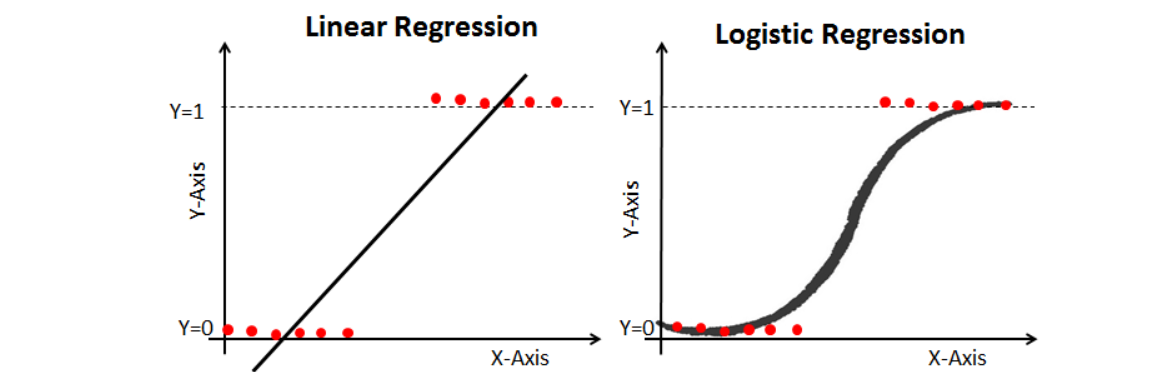
Щоб подолати ці проблеми, в задачах класифікації ми використовуємо логістичну регресію, яка перетворює пряму лінію, що найкраще апроксимує дані, в лінійній регресії на S-криву за допомогою сигмоїдної функції, яка завжди дає значення від 0 до 1.

In [ ]:
#  Створення і навчання класифікатора  на  навчальному наборі даних
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression() 

# навчаємо модель на навчальній вибірці - X_train, y_train
lr.fit(X_train, y_train)

# робимо прогноз цільової змінної на тестовій вибірці - X_test
y_pred_lr = lr.predict(X_test)

###   Матриця помилок та оцінка точності  класифікації  
Далі необхідно оцінити якість класифікатора. Це можна зробити за допомогою classification_report - таблиці, що містить основні метрики для оцінювання точності класифікації та матриці помилок (Confusion Matrix).  
#### Матриця помилок  

Матриця 2x2, що позначає правильні та неправильні передбачення, може допомогти нам проаналізувати точність класифікації. Ця матриця називається матрицею помилок.

$$
\text{Confusion\_Matrix} =
\begin{array}{c|cc}
 & \text{0\_pred} & \text{1\_pred} \\
\hline
\text{0\_true} & TN & FP \\
\text{1\_true} & FN & TP
\end{array}
$$

Горизонтальна вісь відповідає прогнозованим значенням (y-predicted), а вертикальна вісь — фактичним значенням  фактичним значенням (y-actual).

TN представляє значення, які спрогнозовані як хибні та насправді є хибними.  
FP представляє значення, які спрогнозовані як істинні, але є хибними.  
FN представляє значення, які спрогнозовані як хибні, але є істинними.  
TP представляє значення, які спрогнозовані як істинні та насправді є істинними.    

#### Classification_report - таблиця, що містить основні метрики для оцінювання точності класифікації:  
- повна точність (accuracy)
- точність (precision)
- повнота (recall)  
- F-міра (F-score)  

Accuracy класифікатора вимірюється як частка спостережень, які були правильно класифіковані: 
$$Accuracy = (TP+TN)/(TP + FP + FN + TN)$$  
І навпаки, помилка класифікації визначається як частка спостережень, які були неправильно класифіковані.

Детально формули та тлумачення  метрик для оцінювання точності класифікації ви можете переглянути тут https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd#:~:text=Accuracy%20represents%20the%20number%20of,the%20accuracy%20will%20be%2085%25 або скористатися іншим джерелом інформації, яке вам більше подобається.

In [ ]:
#Оцінимо якість класифікатора
from sklearn.metrics import classification_report 
# Порівнюючи  результати  класифікатора  (y_pred_lr) з  фактично  відомими  даними тестового набору (y_test),  можна робити висновок про точність класифікатора
print(classification_report(y_test, y_pred_lr, digits=3))

В перших двох рядках наведено значення precision, recall та f1-score для кожного класу окремо.  
Третій рядок - значення accuracy  
4-й, 5-й рядки - середні значення precision, recall та f1-score  
support - кількість спостережень.  
Відповідно всього 156 спостережень, з яких 95 належить до першого класу, 61 - до другого.  
Accuracy = 0,968 - логістична регресія правильно класифікувала 96,8% спостережень

In [ ]:
# Побудуємо матрицю помилок
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# матриця помилок
cm = confusion_matrix(y_test, y_pred_lr)

# візуалізація матриці помилок
cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1']) 
# display_label - задаються назви класів
cmd.plot()

"Нешахрайські" фірми (у = 0): правильно класифіковано 93 фірми, неправильно - 2 фірми  
"Шахрайські" фірми (у = 1): правильно класифіковано 58 фірм, неправильно - 3 фірми  

За всіма показниками отримано, що точність класифікації логістичної регресії є дуже високою.  

Аналогічно реалізуємо два наступних алгоритми класифікації

### 3. Метод найближчих сусідів (KNN)  
Алгоритм K-NN передбачає подібність між новим випадком/даними та доступними K випадками та поміщає новий випадок до категорії, яка найбільше схожа на доступні категорії.  
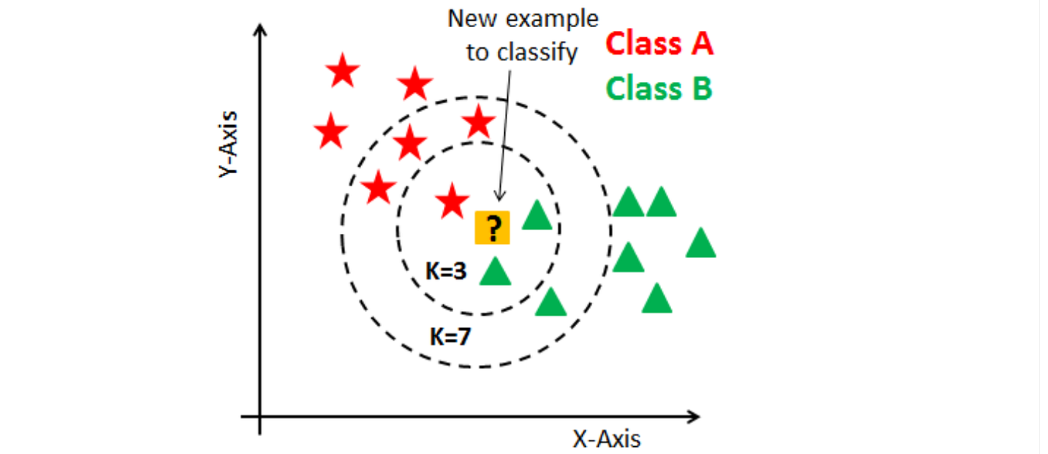

In [ ]:
#  Створення і навчання класифікатора  на  навчальному наборі даних
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

# робимо прогноз на тестовій вибірці - X_test
y_pred_KNN = KNN.predict(X_test)

In [ ]:
#Оцінимо якість класифікатора
print(classification_report(y_test, y_pred_KNN, digits=3))

In [ ]:
# Побудуємо матрицю помилок
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# матриця помилок
cm = confusion_matrix(y_test, y_pred_KNN)

# візуалізація матриці помилок
cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1']) 
# display_label - задаються назви класів
cmd.plot()

### 4. Метод опорних векторів (SVM)  
Суть методу опорних векторів (Support Vector Machines, SVM) проста: алгоритм створює лінію або гіперплощину, яка розділяє дані на класи. Основним завданням алгоритму є знайти найбільш правильну лінію, або гіперплощину, що розділяє дані на два класи.  
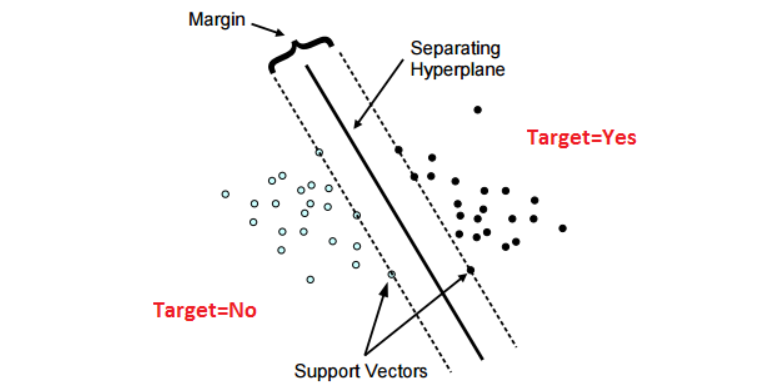

In [ ]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_svm, digits=3))

In [ ]:
# Побудуємо матрицю помилок
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# матриця помилок
cm = confusion_matrix(y_test, y_pred_svm)

# візуалізація матриці помилок
cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1']) 
# display_label - задаються назви класів
cmd.plot()

В цілому всі три методи класифікації показали приблизно однакову високу точність класифікації. Для наших даних перевагу слід надати KNN.  
На основі кращої моделі спрогнозуємо клас ризику, присвоєний аудиторським справам, для 5 нових компаній

In [ ]:
new_companies = pd.read_csv('new_companies.csv')
new_companies

**ВАЖЛИВО** Стандартизація нових даних на основі вже навченого стандартизатора (scaler) є важливою, тому що ми повинні забезпечити однакове масштабування для нових даних, як це було зроблено для даних, на яких навчали алгоритм. Стандартизатор зберігає параметри (середнє значення та стандартне відхилення) для кожної ознаки з тренувальної вибірки, і використання цих самих параметрів дозволяє зберегти узгодженість між новими і старими даними. Це критично для правильного функціонування машинного навчання, оскільки модель навчалася на стандартизованих даних і очікує вхід у тому ж масштабі для правильного прогнозування.

In [ ]:
# стандартизуємо дані
X_new = scaler.fit_transform(new_companies)

In [ ]:
# Прогноз
y_pred_KNN_new = KNN.predict(X_new)

In [ ]:
y_pred_KNN_new

In [ ]:
# додамо спрогнозовані значення цільової змінної до датафрейму
new_companies['Predicted'] = y_pred_KNN_new
new_companies